# Utils / Setup

The following attribute should be set to `False` if running on a Google Colab + Drive.

In [47]:
LOCAL = True

## Not Local (e.g., Google Colab)

In [48]:
#installing NEAT library
if not LOCAL:
  !pip3 install neat-python inspyred gdown

In [49]:
# Note: this cell will install the dependencies pygraphviz and networkx
# If you are using Windows, please follow the instructions that you will find here:
#		https://pygraphviz.github.io/documentation/stable/install.html#windows
# If you are still not able to import pygraphviz due to an error like:
#	'ImportError: DLL load failed while importing _graphviz'
# you may solve this error by adding e.g. "C:\Program Files\Graphviz\bin" to the PATH environment variable.
if not LOCAL:
  !python3 -m pip install networkx
  !apt-get install graphviz graphviz-dev
  !pip install pygraphviz
  !pip install deap

### Drive Management

Firstly, a request to the Drive is made. If succesfull, it might reload the page

In [50]:
if not LOCAL:
  from google.colab import drive
  drive.mount(r"/content/drive", force_remount=True)

In [51]:
if not LOCAL:
  %cd /content/drive/.shortcut-targets-by-id/<your-drive-id>/<your-folder-path>

In [52]:
if not LOCAL:
  %ls

The following methods are useful for plotting and saving the actual results of the model

In [53]:
import matplotlib.pyplot as plt
import os

def plotTree(nodes,edges,labels,name,folder=None):

    if folder is not None and not os.path.exists(folder):
        os.makedirs(folder)

    rounded_labels = {}
    for node, labels in labels.items():
        try:
            rounded_labels[node] = str(round(float(labels), 2))
        except:
            rounded_labels[node] = labels

    if importModule('pygraphviz'):
        import pygraphviz as pgv
        g = pgv.AGraph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        g.layout(prog='dot')
        for i in nodes:
            n = g.get_node(i)
            n.attr['label'] = rounded_labels[i]
        g.draw(folder+'/'+'tree_'+name+'.pdf')

    if importModule('networkx'):
        import networkx as nx
        plt.figure("GP (best tree)")
        g = nx.Graph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        pos = nx.nx_agraph.graphviz_layout(g, prog='dot')
        nx.draw_networkx_nodes(g, pos)
        nx.draw_networkx_edges(g, pos)
        nx.draw_networkx_labels(g, pos, rounded_labels)
        plt.savefig(folder+'/'+'tree_'+name+'.png')

## Formula to Latex converter

In [54]:
import sympy as sp
from IPython.display import display, Math
from deap import gp

def gp_tree_to_sympy_expr(individual, pset):
    """Convert GP tree to SymPy expression"""

    symbols_dict = {}
    for arg_name in pset.arguments:
        symbols_dict[arg_name] = sp.Symbol(arg_name)

    func_mapping = {
        'add': lambda a, b: a + b,
        'sub': lambda a, b: a - b,
        'mul': lambda a, b: a * b,
        'protectedDiv': lambda a, b: a / b,
        'neg': lambda a: -a,
        'cos': lambda a: sp.cos(a),
        'sin': lambda a: sp.sin(a),
        'sqrt': lambda a: sp.sqrt(a),
        'exp': lambda a: sp.exp(a),
        'log': lambda a: sp.log(a),
        'abs': lambda a: sp.Abs(a),
        'pow': lambda a, b: a**b,
    }

    def parse_tree(expr_list):
        if not expr_list:
            return None

        node = expr_list.pop(0)

        if isinstance(node, gp.Primitive):
            func_name = node.name
            args = [parse_tree(expr_list) for _ in range(node.arity)]

            if func_name in func_mapping:
                return func_mapping[func_name](*args)
            else:
                return sp.Function(func_name)(*args)

        elif isinstance(node, gp.Terminal):
            if node.name in symbols_dict:
                return symbols_dict[node.name]
            else:
                value = node.value
                if callable(value):
                    value = value()

                try:
                    return sp.sympify(value)
                except:
                    try:
                        return sp.Float(float(value))
                    except:
                        return sp.Symbol(str(node.name))
        else:
            return sp.sympify(node)

    try:
        expr_list = list(individual)
        expr = parse_tree(expr_list)
        return expr
    except Exception as e:
        print(f"Error: {e}")
        return None

def display_gp_formula_clean(individual, pset, simplify=True, show_fitness=True):
    """Display ONLY the LaTeX formula - clean output"""

    if show_fitness and hasattr(individual, 'fitness') and individual.fitness.values:
        print(f"Fitness: {individual.fitness.values[0]:.6e}")

    expr = gp_tree_to_sympy_expr(individual, pset)

    if expr is not None:
        if simplify:
            try:
                expr = sp.simplify(expr)
            except:
                pass

        expr = expr.xreplace({n: round(n, 2) for n in expr.atoms(sp.Number)})
        display(Math(sp.latex(expr, mul_symbol='dot')))
        return expr
    else:
        print("Could not convert formula")
        return None

## Load the Data

In [55]:
import pandas as pd
import numpy as np
import pyarrow as pa
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 0
MAX_DIM = 1e10
scaler_X = StandardScaler()
# Unregister extension types if they exist
try:
    import pyarrow.pandas_compat
    # This will prevent the duplicate registration error
except Exception:
    pass

df = pd.read_parquet('./data/yeast/processed-downsized.parquet')
df2 = pd.read_parquet('./data/utr5/processed-downsized.parquet')
df3 = pd.read_parquet('./data/sanofi-1st/processed.parquet')

df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
df2 = df2.sample(frac=1, random_state=seed).reset_index(drop=True)
df3 = df3.sample(frac=1, random_state=seed).reset_index(drop=True)

inputs_data = df.iloc[:,2:].to_numpy()
inputs_data2 = df2.iloc[:,2:].to_numpy()
inputs_data3 = df3.iloc[:,2:].to_numpy()

target_data = df['value'].to_list()
target_data2 = df2['value'].to_list()
target_data3 = df3['value'].to_list()

inputs_data = np.nan_to_num(inputs_data, nan=0.0, posinf=MAX_DIM, neginf=-MAX_DIM)
target_data = [MAX_DIM if (math.isnan(x) or math.isinf(x)) else x for x in target_data]

inputs_data2 = np.nan_to_num(inputs_data2, nan=0.0, posinf=MAX_DIM, neginf=-MAX_DIM)
target_data2 = [MAX_DIM if (math.isnan(x) or math.isinf(x)) else x for x in target_data2]

inputs_data3 = np.nan_to_num(inputs_data3, nan=0.0, posinf=MAX_DIM, neginf=-MAX_DIM)
target_data3 = [MAX_DIM if (math.isnan(x) or math.isinf(x)) else x for x in target_data3]

target_data = np.array(target_data)
target_data2 = np.array(target_data2)
target_data3 = np.array(target_data3)

X_train, X_test, y_train, y_test = train_test_split(
    inputs_data,
    target_data,
    test_size=0.20,
    random_state=seed
)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    inputs_data2,
    target_data2,
    test_size=0.20,
    random_state=seed
)

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    inputs_data3,
    target_data3,
    test_size=0.20,
    random_state=seed
)

X_train_final = np.concatenate((X_train, X_train2, X_train3), axis=0)
y_train_final = np.concatenate((y_train, y_train2, y_train3), axis=0)

X_train_final = scaler_X.fit_transform(X_train_final)

y_mean = np.mean(y_train_final)
y_std = np.std(y_train_final)
y_train_std = (y_train_final - y_mean) / y_std



X_test_final = np.concatenate((X_test, X_test2, X_test3), axis=0)
y_test_final = np.concatenate((y_test, y_test2, y_test3), axis=0)

y_test_std = (y_test_final - y_mean) / y_std
X_test_final = scaler_X.transform(X_test_final)

perm_train = np.random.permutation(len(X_train_final))
X_train_final = X_train_final[perm_train]
y_train_final = y_train_final[perm_train]

perm_test = np.random.permutation(len(X_test_final))
X_test_final = X_test_final[perm_test]
y_test_final = y_test_final[perm_test]

print("Shape finale Train:", X_train_final.shape)
print("Shape finale Test:", X_test_final.shape)

display('Example of the processed data:')
display(df2)

Shape finale Train: (3501, 7)
Shape finale Test: (876, 7)


'Example of the processed data:'

,sequence,value,GC,ramp_cai,tail_cai,kozak,CPB,mfe_global,mfe_start
0,TTGTATTTGTTGTTTTTTTTTTTTTTATTATATTTTATTGTATGGA...,0.898945,0.585714,0.8555,0.8780,3.0,-0.052604,-261.299988,-0.800000
1,CCGGAGTGTGTTGGTAGGGTGGGCCCTGGGGACAGGATGTCTCTTC...,0.360702,0.614286,0.9415,0.8776,6.0,-0.049022,-279.399994,-11.700000
2,AAATTTCTGTTTTTTGTTTGTTTGTTTTTTTCGTATATTATATGGA...,0.890690,0.589610,0.8555,0.8780,3.0,-0.052604,-263.299988,-2.300000
3,CGCCCGAACCGCATGCACGGGGAAAAAGACGGTCGTATGCCAAGCA...,0.410414,0.615584,0.9415,0.8776,3.0,-0.049022,-270.399994,-9.900000
4,GCAGCTGCGGACTTGTCCCCGTATGGAGCCCAGCGCCCCGCCTGGA...,0.355381,0.622078,0.9415,0.8776,4.0,-0.049022,-280.000000,-14.500000
...,...,...,...,...,...,...,...,...,...
1454,TTTTTGCGAAATCCATTATTTCTATTATTGTTTTTTTGGAAACTGT...,0.539080,0.593506,0.9415,0.8776,7.0,-0.049022,-263.799988,-4.100000
1455,GGAGTGTCATCCCAGCCTCGAACCTGGGGAGCTTTCTAAGACTCCC...,0.586825,0.612987,0.9415,0.8776,6.0,-0.049022,-274.200012,-14.800000
1456,CTTCTGTAGGAGGAATACTGTTGGCGTTCAAAAGCATTACTGTTTC...,0.838884,0.601299,0.9415,0.8776,6.0,-0.049022,-266.100006,-5.100000
1457,CCCCTCCTGCGGCAATGACTGCGTAAAGCCTGTTGTGTTATTACTC...,0.403779,0.609091,0.9415,0.8776,6.0,-0.049022,-266.500000,-7.400000


# Genetic Programming Model

/mnt/c/users/nizar/desktop/magistrale/Bio-Inspired AI/venv/lib/python3.10/site-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


   	      	                              fitness                              	                     size                     
   	      	-------------------------------------------------------------------	----------------------------------------------
gen	nevals	avg     	gen	max  	min     	nevals	std        	avg   	gen	max	min	nevals	std   
0  	2000  	7.75e+09	0  	1e+10	0.550793	2000  	4.17582e+09	13.264	0  	97 	3  	2000  	12.781
1  	1697  	3.69e+09	1  	1e+10	0.550793	1697  	4.82534e+09	9.0255	1  	71 	1  	1697  	6.55331
2  	1690  	2.28e+09	2  	1e+10	0.550793	1690  	4.19543e+09	8.2195	2  	33 	1  	1690  	4.98802
3  	1727  	2.4e+09 	3  	1e+10	0.550793	1727  	4.27083e+09	8.395 	3  	33 	1  	1727  	4.98969
4  	1706  	2.01e+09	4  	1e+10	0.550793	1706  	4.00748e+09	8.954 	4  	33 	1  	1706  	5.00269
5  	1695  	2.035e+09	5  	1e+10	0.534533	1695  	4.02601e+09	9.2235	5  	32 	1  	1695  	4.88165
6  	1680  	1.765e+09	6  	1e+10	0.534533	1680  	3.81245e+09	9.658 	6  	32 	1  	1680  	4.56859
7  	1646  	2

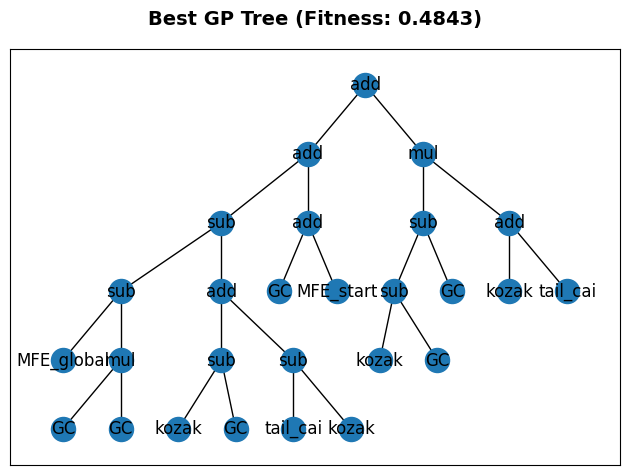

In [56]:
import sys
import time
import operator
import math
import random
import pandas as pd
import math
import numpy as np


import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
import os
import importlib

GP_POP_SIZE = 2000                #population size for GP
GP_NGEN = 50                     # number of generations for GP
GP_CXPB, GP_MUTPB = 0.7, 0.5      # crossover and mutation probability for GP (più esplorazione)
GP_TRNMT_SIZE = 7                 # tournament size for GP (ridotto per diversità)
GP_HOF_SIZE = 3                   #size of the Hall-of-Fame for GP
seed = 0

#### ERROR MAX VALUE
MAX_DIM = 1e10


folder = 'results'

def importModule(module):
    try:
        found = True
        importlib.import_module(module)
    except ImportError:
        found = False
        print("Module " + module + " not found")
    return found

# Define new functions
def protectedDiv(left, right):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(np.abs(right) < 1e-6, 1, left / right)
    return result

def protectedLog(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.log(x)
        # Return nan for non-positive inputs
        return np.where(x <= 0, np.nan, result)

def protectedSqrt(x):
    with np.errstate(invalid='ignore'):
        result = np.sqrt(x)
        # Return nan for negative inputs
        return np.where(x < 0, np.nan, result)

def protectedExp(x):
    with np.errstate(over='ignore'):
        x_clipped = np.clip(x, -100, 100)  # Prevent overflow
        return np.exp(x_clipped)

def protectedPow(x, y):
    with np.errstate(over='ignore', invalid='ignore'):
        y_clipped = np.clip(y, -10, 10)
        return np.where(
            np.abs(x) > 1e-6,
            np.sign(x) * np.abs(x) ** y_clipped,
            0
        )

pset = gp.PrimitiveSet("MAIN", 7)

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(protectedLog, 1, name='log')
pset.addPrimitive(protectedSqrt, 1, name='sqrt')
pset.addPrimitive(protectedExp, 1, name='exp')
#pset.addPrimitive(protectedPow, 2, name='pow')

try:
    pset.addEphemeralConstant("rand101", lambda: random.uniform(-5, 5))
except:
    print("EphemeralConstant is already defined, if you changed it restart the kernel")

#parameters of the mrna sequence
pset.renameArguments(ARG0='GC')
pset.renameArguments(ARG1='ramp_cai')
pset.renameArguments(ARG2='tail_cai')
pset.renameArguments(ARG3='kozak')
pset.renameArguments(ARG4='CPB')
pset.renameArguments(ARG5='MFE_global')
pset.renameArguments(ARG6='MFE_start')
#pset.renameArguments(ARG7='CPB')

try:
    del creator.FitnessMinSR
    del creator.IndividualSR
except:
    pass
creator.create("FitnessMinSR", base.Fitness, weights=(-1.0,))
creator.create("IndividualSR", gp.PrimitiveTree, fitness=creator.FitnessMinSR)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=6)
toolbox.register("individual", tools.initIterate, creator.IndividualSR, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


x_train = X_train_final
y_train = y_train_final
x_test = X_test_final
y_test = y_test_final

def evalSymbReg(individual, inputs, targets):
    func = toolbox.compile(expr=individual)
    try:
        prediction = func(*inputs.T)

        if isinstance(prediction, (int, float, np.float64, np.float32)):
            prediction = np.full(shape=targets.shape, fill_value=prediction)

        if np.isnan(prediction).any() or np.isinf(prediction).any():
             return (MAX_DIM,)
        slope, intercept, r_value, p_value, std_err = linregress(prediction, targets)

        if np.isnan(slope):
            return (MAX_DIM,)

        prediction_scaled = slope * prediction + intercept

        # Percentile-based Loss: 60% RMSE + 40% 95th percentile error
        # Focus sugli errori estremi (valori alti dispersi)
        errors = np.abs(prediction_scaled - targets)
        squared_errors = (prediction_scaled - targets) ** 2
        mse = np.mean(squared_errors)
        rmse = np.sqrt(mse)

        # 95° percentile: si concentra sugli errori più grandi (top 5%)
        percentile_95 = np.percentile(errors, 95)

        # Combinazione: 60% RMSE + 40% 95th percentile (più focus su valori estremi)
        combined_loss = 2*(0.6 * rmse + 0.4 * percentile_95)

        complexity_penalty = len(individual) * 0.000005
        fitness = combined_loss + complexity_penalty

        return (fitness,)
    except Exception:
        return (MAX_DIM,)

toolbox.register("evaluate", evalSymbReg, inputs=X_train_final, targets=y_train_final)
toolbox.register("select", tools.selTournament, tournsize=GP_TRNMT_SIZE)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=4)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# limit height of individuals
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

# and the number of nodes
toolbox.decorate("mate", gp.staticLimit(key=len, max_value=300))
toolbox.decorate("mutate", gp.staticLimit(key=len, max_value=300))

random.seed(seed)

pop = toolbox.population(n=GP_POP_SIZE)
hof = tools.HallOfFame(GP_HOF_SIZE)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

final_pop,logbook=algorithms.eaSimple(pop, toolbox, GP_CXPB, GP_MUTPB, GP_NGEN, \
                                      stats=mstats, halloffame=hof, verbose=True)

nodes, edges, labels = gp.graph(hof[0])
plotTree(nodes,edges,labels,'symbreg_'+str(seed),'results')
plt.figure("GP (best tree)")
plt.suptitle(f"Best GP Tree (Fitness: {hof[0].fitness.values[0]:.4f})",
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()

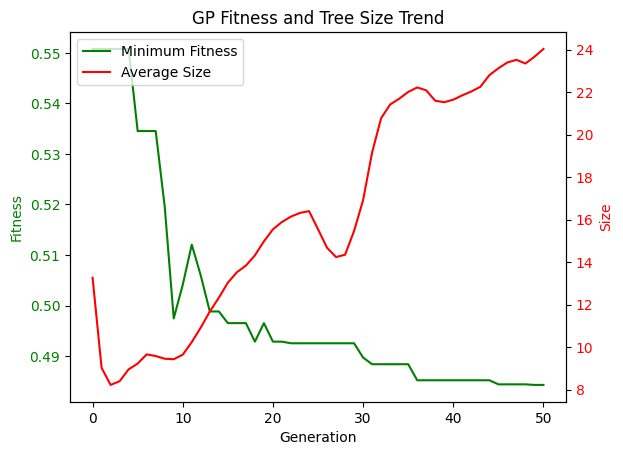

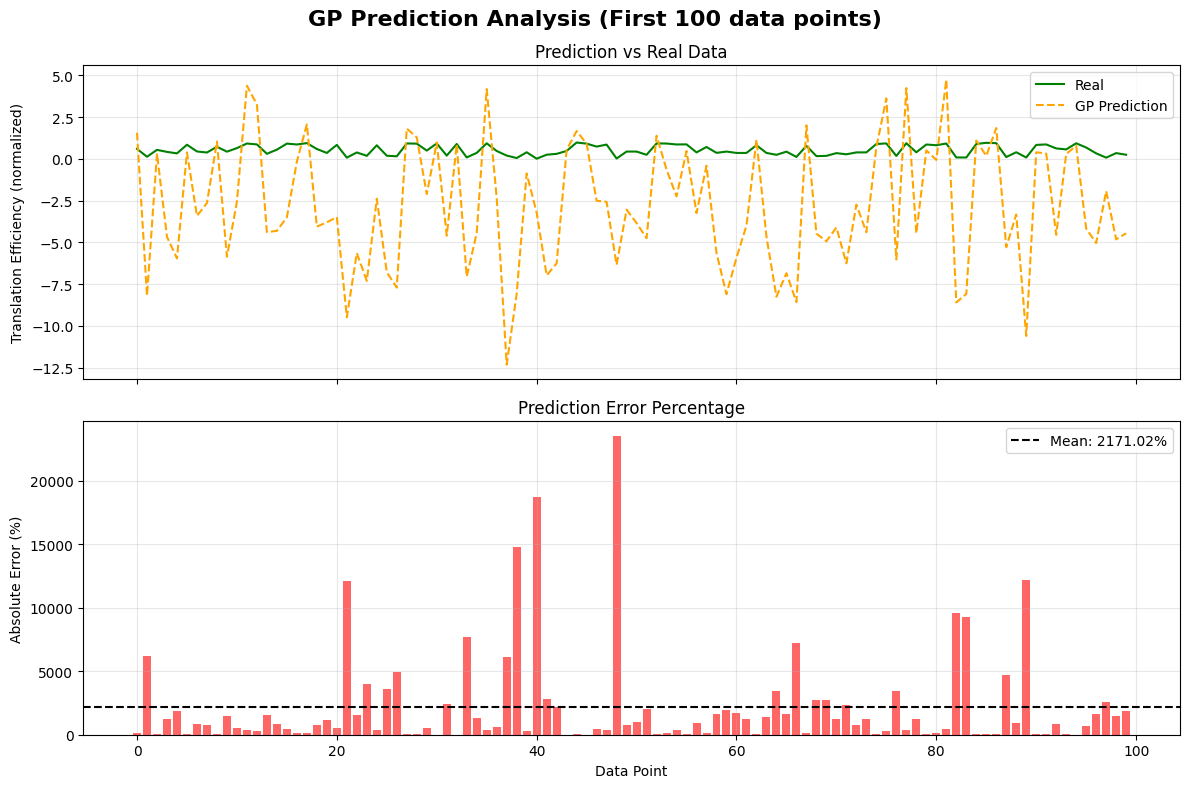

Best individual GP is add(add(sub(sub(MFE_global, mul(GC, GC)), add(sub(kozak, GC), sub(tail_cai, kozak))), add(GC, MFE_start)), mul(sub(sub(kozak, GC), GC), add(kozak, tail_cai))), (np.float64(0.4842837763419361),)
Parametri di Scaling Linear: Slope=0.0606, Intercept=0.7156
Test MSE (Scaled): 0.032827
Test R2 (Scaled): 0.626665


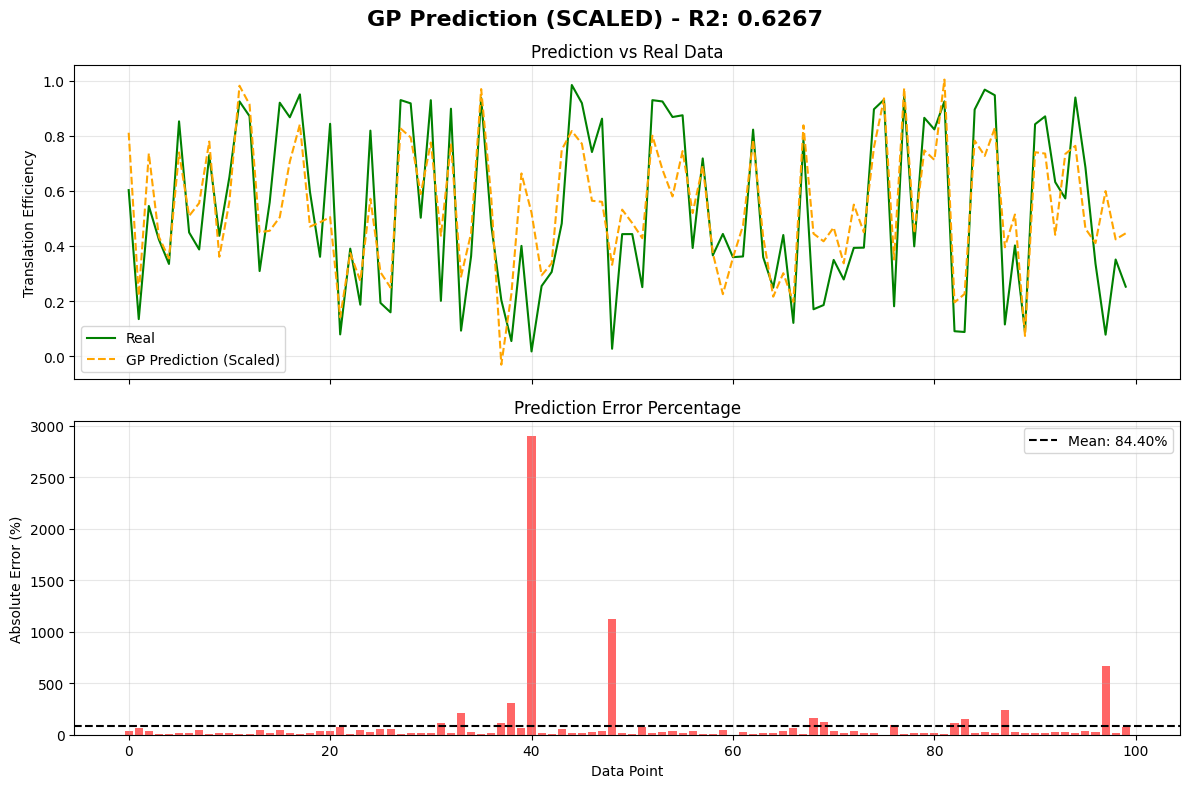

In [57]:
import matplotlib.pyplot as plt

# in the plots, limit the number of points shown to avoid overcrowding
POINTS_TO_PLOT = 100
points_shown = min(POINTS_TO_PLOT, len(y_test_final)) # Use y_test_final length

y_real = y_test_final[:points_shown] # Use y_test_final
x_ = np.arange(points_shown)

gpFunction = toolbox.compile(expr=hof[0])
y_gp = [gpFunction(*args) for args in X_test_final[:points_shown]] # Use X_test_final.T

gen = logbook.select("gen")
fit_mins = logbook.chapters["fitness"].select("min")
size_avgs = logbook.chapters["size"].select("avg")

fig = plt.figure("GP (fitness and tree size trend)")
ax1 = fig.add_subplot(111)
line1 = ax1.plot(gen, fit_mins, "g-", label="Minimum Fitness")
ax1.set_ylabel("Fitness", color="g")
ax1.set_xlabel("Generation")
ax1.set_title("GP Fitness and Tree Size Trend")
for tl in ax1.get_yticklabels():
    tl.set_color("g")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

if folder is not None and not os.path.exists(folder):
    os.makedirs(folder)
plt.savefig(folder+'/'+'trends_symbreg.png')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle(f"GP Prediction Analysis (First {points_shown} data points)",
             fontsize=16, fontweight='bold')

# First subplot: Real vs Predicted
ax1.plot(x_, y_real, label="Real", color="green")
ax1.plot(x_, y_gp, label="GP Prediction", color="orange", linestyle="--")
ax1.set_ylabel("Translation Efficiency (normalized)")
ax1.set_title("Prediction vs Real Data")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second subplot: Percentage Error
y_real_arr = np.array(y_real)
y_gp_arr = np.array(y_gp)

with np.errstate(divide='ignore', invalid='ignore'):
    percentage_error = np.where(
        np.abs(y_real_arr) > 1e-10,
        100 * np.abs(y_real_arr - y_gp_arr) / np.abs(y_real_arr),
        0
    )

ax2.bar(x_, percentage_error, color='red', alpha=0.6)
ax2.set_xlabel("Data Point")
ax2.set_ylabel("Absolute Error (%)")
ax2.set_title("Prediction Error Percentage")
ax2.axhline(y=np.mean(percentage_error), color='black', linestyle='--',
            label=f'Mean: {np.mean(percentage_error):.2f}%')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


best_ind = hof[0]
func = toolbox.compile(expr=best_ind)

print("Best individual GP is %s, %s" % (best_ind, best_ind.fitness.values))

def get_raw_predictions(func, inputs):
    try:
        raw_pred = func(*inputs.T)

        if isinstance(raw_pred, (int, float, np.float64, np.float32)):
            raw_pred = np.full(shape=inputs.shape[0], fill_value=raw_pred)

        raw_pred = np.nan_to_num(raw_pred, nan=0.0, posinf=0.0, neginf=0.0)
        return raw_pred
    except Exception:
        return np.zeros(inputs.shape[0])

from scipy.stats import linregress

y_train_pred_raw = get_raw_predictions(func, X_train_final)
slope, intercept, r_value, p_value, std_err = linregress(y_train_pred_raw, y_train_final)

print(f"Parametri di Scaling Linear: Slope={slope:.4f}, Intercept={intercept:.4f}")

y_test_pred_raw = get_raw_predictions(func, X_test_final)
y_gp_test_scaled = slope * y_test_pred_raw + intercept

import matplotlib.pyplot as plt

# Plot settings
POINTS_TO_PLOT = 100
points_shown = min(POINTS_TO_PLOT, len(y_test_final))

y_real_plot = y_test_final[:points_shown]
y_gp_plot = y_gp_test_scaled[:points_shown]
x_ = np.arange(points_shown)

from sklearn.metrics import mean_squared_error, r2_score
mse_test = mean_squared_error(y_test_final, y_gp_test_scaled)
r2_test = r2_score(y_test_final, y_gp_test_scaled)

print(f"Test MSE (Scaled): {mse_test:.6f}")
print(f"Test R2 (Scaled): {r2_test:.6f}")


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle(f"GP Prediction (SCALED) - R2: {r2_test:.4f}", fontsize=16, fontweight='bold')

ax1.plot(x_, y_real_plot, label="Real", color="green")
ax1.plot(x_, y_gp_plot, label="GP Prediction (Scaled)", color="orange", linestyle="--")
ax1.set_ylabel("Translation Efficiency")
ax1.set_title("Prediction vs Real Data")
ax1.legend()
ax1.grid(True, alpha=0.3)

with np.errstate(divide='ignore', invalid='ignore'):
    percentage_error = np.where(
        np.abs(y_real_plot) > 1e-6,
        100 * np.abs(y_real_plot - y_gp_plot) / np.abs(y_real_plot),
        0
    )

ax2.bar(x_, percentage_error, color='red', alpha=0.6)
ax2.set_xlabel("Data Point")
ax2.set_ylabel("Absolute Error (%)")
ax2.set_title("Prediction Error Percentage")
ax2.axhline(y=np.mean(percentage_error), color='black', linestyle='--',
            label=f'Mean: {np.mean(percentage_error):.2f}%')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Hall of Fame

In [58]:
# --------------------------------------------------------------------
print("Best individual GP is %s, %s" % (hof[0], hof[0].fitness.values))

# Display the best formula
print("="*70)
print("BEST FORMULA")
print("="*70)
best_expr = display_gp_formula_clean(hof[0], pset, simplify=False)

# Display all top formulas
print("\n" + "="*70)
print("OTHER FORMULAS IN THE HOF")
print("="*70)
for i, ind in enumerate(hof[1:]):
    print(f"\n### Individual {i+1} ###")
    display_gp_formula_clean(ind, pset, simplify=False)

Best individual GP is add(add(sub(sub(MFE_global, mul(GC, GC)), add(sub(kozak, GC), sub(tail_cai, kozak))), add(GC, MFE_start)), mul(sub(sub(kozak, GC), GC), add(kozak, tail_cai))), (np.float64(0.4842837763419361),)
BEST FORMULA
Fitness: 4.842838e-01


<IPython.core.display.Math object>


OTHER FORMULAS IN THE HOF

### Individual 1 ###
Fitness: 4.842838e-01


<IPython.core.display.Math object>


### Individual 2 ###
Fitness: 4.842838e-01


<IPython.core.display.Math object>

Scaling Parameters Found: Slope=0.0606, Intercept=0.7156

--- Performance on TRAIN Set (Correct) ---
MSE: 0.031432
R2 Score: 0.6217

--- Performance on TEST Set (Correct) ---
MSE: 0.032827
R2 Score: 0.6267


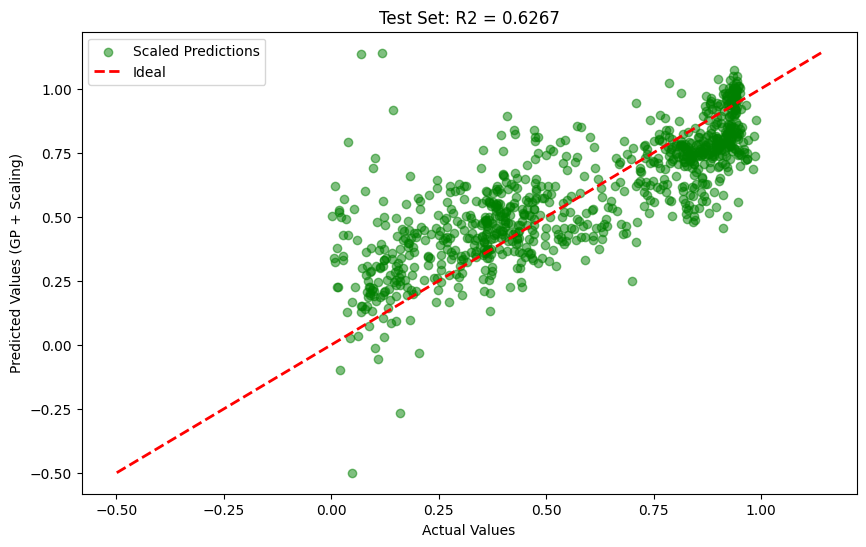

In [59]:
from scipy.stats import linregress

def get_linear_scaling_params(individual, X, y):
    """Calculate optimal slope and intercept on the training set"""
    func = toolbox.compile(expr=individual)
    y_pred_raw = func(*X.T)

    # Handle NaN/Inf
    if isinstance(y_pred_raw, (int, float)):
        y_pred_raw = np.full(shape=y.shape, fill_value=y_pred_raw)
    y_pred_raw = np.nan_to_num(y_pred_raw, nan=0.0, posinf=0.0, neginf=0.0)

    # Perform regression
    slope, intercept, r_value, p_value, std_err = linregress(y_pred_raw, y)
    return slope, intercept

def predict_with_scaling(individual, X, slope, intercept):
    """Apply the GP formula with linear scaling"""
    func = toolbox.compile(expr=individual)
    y_pred_raw = func(*X.T)

    # Handle NaN/Inf
    if isinstance(y_pred_raw, (int, float)):
        y_pred_raw = np.full(shape=X.shape[0], fill_value=y_pred_raw)
    y_pred_raw = np.nan_to_num(y_pred_raw, nan=0.0, posinf=0.0, neginf=0.0)

    # Apply scaling: y = mx + q
    return slope * y_pred_raw + intercept

# --- CORRECT EXECUTION ---

if len(hof) > 0:
    best_ind = hof[0]

    # 1. Calculate scaling parameters ONLY on the Training Set
    # (Do not cheat by using the Test set to calculate these numbers!)
    slope, intercept = get_linear_scaling_params(best_ind, X_train_final, y_train_final)

    print(f"Scaling Parameters Found: Slope={slope:.4f}, Intercept={intercept:.4f}")

    # 2. Evaluate on TRAIN with scaling
    print("\n--- Performance on TRAIN Set (Correct) ---")
    y_pred_train_scaled = predict_with_scaling(best_ind, X_train_final, slope, intercept)
    mse_train = mean_squared_error(y_train_final, y_pred_train_scaled)
    r2_train = r2_score(y_train_final, y_pred_train_scaled)
    print(f"MSE: {mse_train:.6f}")
    print(f"R2 Score: {r2_train:.4f}")

    # 3. Evaluate on TEST using slope/intercept from the train
    print("\n--- Performance on TEST Set (Correct) ---")
    y_pred_test_scaled = predict_with_scaling(best_ind, X_test_final, slope, intercept)
    mse_test = mean_squared_error(y_test_final, y_pred_test_scaled)
    r2_test = r2_score(y_test_final, y_pred_test_scaled)
    print(f"MSE: {mse_test:.6f}")
    print(f"R2 Score: {r2_test:.4f}")

    # 4. Correct Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_final, y_pred_test_scaled, alpha=0.5, color='green', label='Scaled Predictions')

    min_val = min(np.min(y_test_final), np.min(y_pred_test_scaled))
    max_val = max(np.max(y_test_final), np.max(y_pred_test_scaled))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')

    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values (GP + Scaling)")
    plt.title(f"Test Set: R2 = {r2_test:.4f}")
    plt.legend()
    # plt.grid(True, alpha=0.3)
    plt.show()